# Week 2 Exercise - Using DNN to forecast time series

This notebook covers all the content seen during week 2 of Time Series forecasting using DNN 

- Creation of a windowed dataset
- Split features and labels
- Create a model with multiple Dense layers
- Evaluate performance
- Tune Learning Rate

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    '''
    Plot series of data

    Parameters
    ----------
    time : array of data
    series: array of data to plot in Y axis 
    format: format of basic line properties. Ref: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.plot.html
    start: from where to start plotting, optional. Default: 0
    end: up to where to plot data, optional. Default: None
    '''
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

In [4]:
def trend(time, slope=0):
    '''
    Produce a trend of data.
    Parameters
    ---------- 
    time: time series to plot 
    slope: slope to plot the series. optional, Default: 0
    '''    
    return slope * time

In [85]:
def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern by using np.where
    Ref: https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html
    
    Parameters
    ----------
    season_time: to generate the condition of what to select from 
    """
    return np.where(season_time < 0.1,
                    np.cos(season_time * 4 * np.pi),
                    1 / np.exp(8 * season_time))

In [86]:
def seasonality(time, period, amplitude=1, phase=0):
    '''
    Repeats the same pattern at each period
    
    Parameters
    ----------
    time: to generate the season over x axis 
    period: how often will repeat
    amplitude: how many phases 
    phase: the position of the point in time
    '''
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

In [87]:
def noise(time, noise_level=1, seed=None):
    '''
    Produce random noise into a time series 

    Parameters
    ----------
    time: series of values on X axis
    noise_level: to be produced, optional. Default: 1
    seed: seed to generate the noise, optional. Default: None 
    '''
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [88]:
time = np.arange(10 * 365 + 1, dtype="float32")

In [89]:
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

In [90]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

In [91]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [92]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

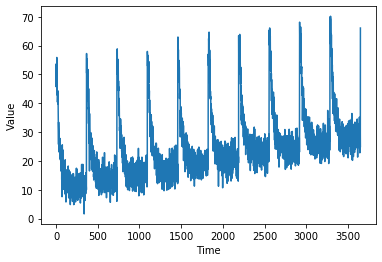

In [93]:
plot_series(time, series)

Desired output -- a chart that looks like this:

![Chart showing upward trend and seasonailty](http://www.laurencemoroney.com/wp-content/uploads/2019/07/plot1.png)

In [94]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    Creates a windowed dataset and returns only one from the batch 
    
    Parameters
    ----------
    series: time series data to set as dataset
    windows_size: size of the window to be created
    batch_size: size of the batch by window 
    shuffle_buffer: buffer size to take data and shuffle it around
    
    Returns a transformed dataset
    """
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [95]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [113]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size],activation='relu'),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

In [114]:
initial_lr = 1e-10
# Define learning rate scheduler 
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: initial_lr * 10**(epoch / 20))

In [115]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=initial_lr, momentum=0.9))

In [118]:
history_lr = model.fit(dataset,epochs=200,callbacks=[lr_schedule], verbose=0)

[1e-10, 0.001, 0, 40]

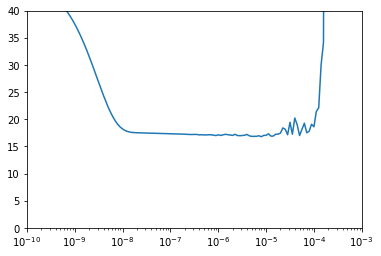

In [130]:
# Plot the learning rates across training 
lrs = initial_lr * (10 ** (np.arange(200) / 20))
plt.semilogx(lrs, history_lr.history["loss"])
plt.axis([initial_lr, 1e-3, 0, 40])

In [123]:
min_loss = min(history_lr.history["loss"])
print(min_loss)

16.7947065628615


In [128]:
min_loss_idx = history_lr.history["loss"].index(min_loss)
print(min_loss_idx)
print("Minimum loss at learning rate {}".format(lrs[min_loss_idx]))

98
Minimum loss at learning rate 7.943282347242822e-06


In [134]:
tuned_learning_rate = 7e-6

In [135]:
window_size = 30

# Create a new windowed dataset
new_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [136]:
# Create a model with 3 layers 
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

In [137]:
# Create the optimizer with the new learning rate after tuning 
optimizer = tf.keras.optimizers.SGD(lr=tuned_learning_rate, momentum=0.9)

# Configure the model with MSE loss and SGD optimizer
model.compile(loss="mse", optimizer=optimizer)

In [138]:
# Train the model for 500 epochs
history = model.fit(new_dataset, epochs=500, verbose=1)

Epoch 1/500
93/93 [==============================] - 1s 6ms/step - loss: 42.2312
Epoch 2/500
93/93 [==============================] - 0s 4ms/step - loss: 26.2414
Epoch 3/500
93/93 [==============================] - 0s 3ms/step - loss: 23.0841
Epoch 4/500
93/93 [==============================] - 0s 4ms/step - loss: 22.3529
Epoch 5/500
93/93 [==============================] - 0s 4ms/step - loss: 22.1967
Epoch 6/500
93/93 [==============================] - 0s 4ms/step - loss: 20.0254
Epoch 7/500
93/93 [==============================] - 0s 4ms/step - loss: 19.3122
Epoch 8/500
93/93 [==============================] - 0s 4ms/step - loss: 18.9063
Epoch 9/500
93/93 [==============================] - 0s 3ms/step - loss: 18.4888
Epoch 10/500
93/93 [==============================] - 0s 4ms/step - loss: 18.1871
Epoch 11/500
93/93 [==============================] - 0s 4ms/step - loss: 18.3968
Epoch 12/500
93/93 [==============================] - 0s 4ms/step - loss: 17.1887
Epoch 13/500
93/93 [=====

93/93 [==============================] - 0s 4ms/step - loss: 15.4322
Epoch 102/500
93/93 [==============================] - 0s 4ms/step - loss: 15.3944
Epoch 103/500
93/93 [==============================] - 0s 4ms/step - loss: 15.7743
Epoch 104/500
93/93 [==============================] - 0s 4ms/step - loss: 15.5433
Epoch 105/500
93/93 [==============================] - 0s 4ms/step - loss: 15.7635
Epoch 106/500
93/93 [==============================] - 0s 4ms/step - loss: 15.5354
Epoch 107/500
93/93 [==============================] - 0s 4ms/step - loss: 15.6512
Epoch 108/500
93/93 [==============================] - 0s 4ms/step - loss: 14.8069
Epoch 109/500
93/93 [==============================] - 0s 4ms/step - loss: 15.3302
Epoch 110/500
93/93 [==============================] - 0s 4ms/step - loss: 15.7102
Epoch 111/500
93/93 [==============================] - 0s 3ms/step - loss: 15.6979
Epoch 112/500
93/93 [==============================] - 0s 4ms/step - loss: 15.3835
Epoch 113/500
93/9

93/93 [==============================] - 0s 4ms/step - loss: 15.4155
Epoch 200/500
93/93 [==============================] - 0s 4ms/step - loss: 15.5365
Epoch 201/500
93/93 [==============================] - 0s 3ms/step - loss: 15.4063
Epoch 202/500
93/93 [==============================] - 0s 4ms/step - loss: 15.2556
Epoch 203/500
93/93 [==============================] - 0s 4ms/step - loss: 15.0969
Epoch 204/500
93/93 [==============================] - 0s 4ms/step - loss: 14.6333
Epoch 205/500
93/93 [==============================] - 0s 4ms/step - loss: 15.3304
Epoch 206/500
93/93 [==============================] - 0s 4ms/step - loss: 15.0823
Epoch 207/500
93/93 [==============================] - 0s 4ms/step - loss: 15.1568
Epoch 208/500
93/93 [==============================] - 0s 4ms/step - loss: 15.0625
Epoch 209/500
93/93 [==============================] - 0s 4ms/step - loss: 15.4655
Epoch 210/500
93/93 [==============================] - 0s 4ms/step - loss: 15.1755
Epoch 211/500
93/9

93/93 [==============================] - 0s 4ms/step - loss: 15.2935
Epoch 298/500
93/93 [==============================] - 0s 3ms/step - loss: 14.9914
Epoch 299/500
93/93 [==============================] - 0s 4ms/step - loss: 15.0365
Epoch 300/500
93/93 [==============================] - 0s 4ms/step - loss: 14.8520
Epoch 301/500
93/93 [==============================] - 0s 4ms/step - loss: 14.8607
Epoch 302/500
93/93 [==============================] - 0s 4ms/step - loss: 15.0704
Epoch 303/500
93/93 [==============================] - 0s 3ms/step - loss: 15.5457
Epoch 304/500
93/93 [==============================] - 0s 4ms/step - loss: 14.9096
Epoch 305/500
93/93 [==============================] - 0s 4ms/step - loss: 15.0018
Epoch 306/500
93/93 [==============================] - 0s 4ms/step - loss: 14.9356
Epoch 307/500
93/93 [==============================] - 0s 4ms/step - loss: 14.9317
Epoch 308/500
93/93 [==============================] - 0s 4ms/step - loss: 15.0594
Epoch 309/500
93/9

93/93 [==============================] - 0s 4ms/step - loss: 14.9040
Epoch 396/500
93/93 [==============================] - 0s 4ms/step - loss: 14.8721
Epoch 397/500
93/93 [==============================] - 0s 4ms/step - loss: 14.8966
Epoch 398/500
93/93 [==============================] - 0s 3ms/step - loss: 14.9397
Epoch 399/500
93/93 [==============================] - 0s 4ms/step - loss: 14.1936
Epoch 400/500
93/93 [==============================] - 0s 4ms/step - loss: 15.3591
Epoch 401/500
93/93 [==============================] - 0s 3ms/step - loss: 14.7999
Epoch 402/500
93/93 [==============================] - 0s 4ms/step - loss: 15.0059
Epoch 403/500
93/93 [==============================] - 0s 4ms/step - loss: 14.8909
Epoch 404/500
93/93 [==============================] - 0s 4ms/step - loss: 15.1298
Epoch 405/500
93/93 [==============================] - 0s 4ms/step - loss: 14.9354
Epoch 406/500
93/93 [==============================] - 0s 4ms/step - loss: 14.5093
Epoch 407/500
93/9

93/93 [==============================] - 0s 4ms/step - loss: 14.8358
Epoch 494/500
93/93 [==============================] - 0s 4ms/step - loss: 14.8211
Epoch 495/500
93/93 [==============================] - 0s 3ms/step - loss: 14.7101
Epoch 496/500
93/93 [==============================] - 0s 4ms/step - loss: 14.0616
Epoch 497/500
93/93 [==============================] - 0s 4ms/step - loss: 14.8975
Epoch 498/500
93/93 [==============================] - 0s 3ms/step - loss: 14.8132
Epoch 499/500
93/93 [==============================] - 0s 4ms/step - loss: 14.7610
Epoch 500/500
93/93 [==============================] - 0s 4ms/step - loss: 14.4242


In [139]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

In [140]:
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

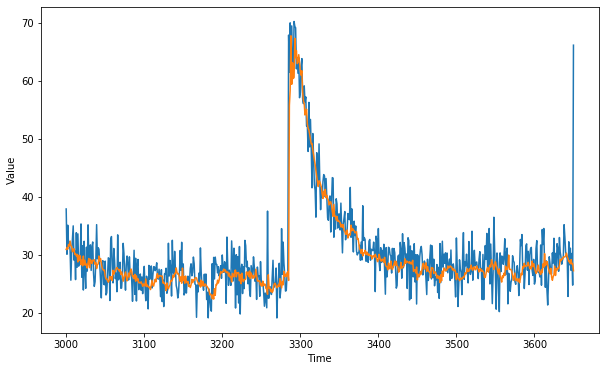

In [141]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [142]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# EXPECTED OUTPUT
# A Value less than 3

2.7629092